In [13]:


from PIL import Image

import os
from os.path import split,join, isdir ,exists
os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
from loguru import logger
import torch
import numpy as np
import skimage
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image

from utils import *
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率


from utils.entity.bsds_rind_gt_loader import * 
from utils.entity.bsds_rind_qualitative_drawer import * 


In [10]:


def get_best_image(main_drawer,other_drawer_list,task = 'reflectance'):

    n =  len(other_drawer_list)

    distance_dict = {}
    
    for index in range(main_drawer.__len__()):

        main_f, name  = main_drawer.get_task_F_quantitatives(task,index)
        distance = 0 


        for d in other_drawer_list:
            distance += (main_f - d.get_task_F_quantitatives(task,index)[0])

        
        distance_dict[name] = distance/n

    
    return  sorted(distance_dict.items(), key =lambda k : k[1])[::-1]
    

RINDNET_ROOT="/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/trash/precomputed"

our_drawer = QualitativeDrawer('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/full_version_0','ours')
rindnet_drawer = QualitativeDrawer(join(RINDNET_ROOT,"rindnet-resnet50"),'rindnet')
dff_drawer = QualitativeDrawer(join(RINDNET_ROOT,"dff"),'dff')
rcf_drawer = QualitativeDrawer(join(RINDNET_ROOT,"rcf"),'rcf')
hed_drawer = QualitativeDrawer(join(RINDNET_ROOT,"hed"),'hed')

# our_drawer.get_quantitatives(0)



176051


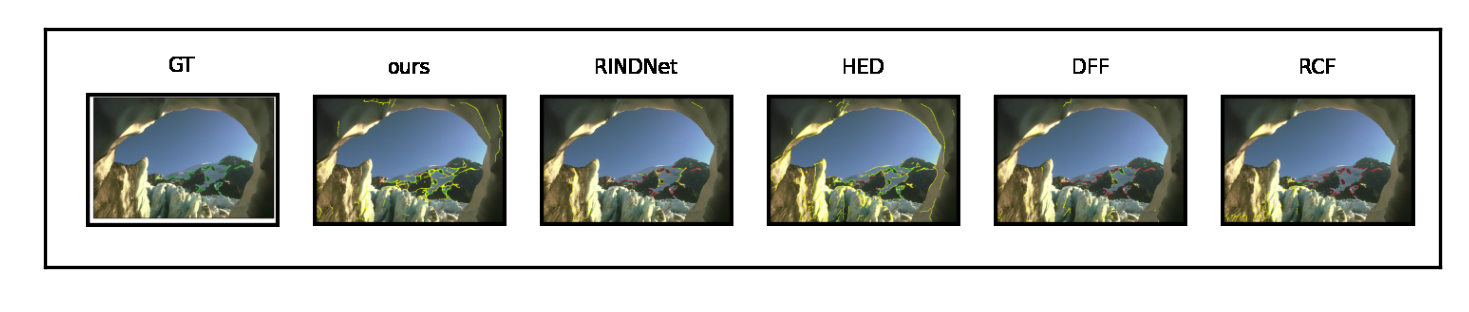

296028
238025
384022
65084
77062
141048
187058
164046
100039
376086
160006
388006
134049
2018
235098
268074
346016
70011
189029
51084
141012
103006
253092
106005
385022
120003
3063
225022
179084
257098
289011
147080
92014
306051
230098
181021
223004
102062
108069
49024
48025
209021
388018
14092
61034
15011
35028
217013
159002
246009
100099
71076
309040
302022
217090
226033
183066
189096
118015
29030
384089
230063
163004
17067
249021
146074
175083
81090
207038
28083
206097
118031
187099
196040
94095
226060
201080
296058
69007
112056
317043
267036
281017
207049
15062
196027
140088
206062
290035
393035
196088
43051
258089
232076
247003
147077
243095
103029
202000
35028
145079
103078
207038
5096
65084
10081
344010
247003
140006
41006
253016
102062
81095
209021
134067
106047
306051
2018
226022
78098
16068
226033
134049
14085
97010
208078
176051
302022
258089
267036
108004
220003
43051
296028
247012
104055
384089
80090
385022
296058
104010
29030
147077
235098
107072
159002
108036
120003
2900

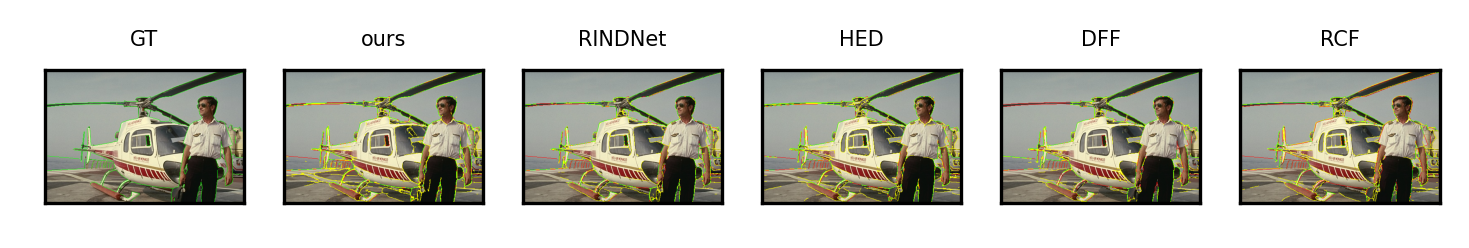

In [11]:
# demo_task = 'reflectance'

best_list = {}

for demo_task in ['reflectance',"illumination","normal","depth"]:
# for demo_task in ['reflectance']:

    demo_threshold_range = [0.5]


    compare_save_dir = 'logs/bsds/compare/%s'%(demo_task)
    make_dir(compare_save_dir)
    origin_save_dir = 'logs/bsds/gt/%s'%(demo_task)
    make_dir(origin_save_dir)

    gt_loader = GtLoader()

    compare_results = get_best_image(our_drawer,[rindnet_drawer,dff_drawer,rcf_drawer,hed_drawer],demo_task)
    top10_name_list = [x[0] for x in compare_results]
    best_list[demo_task ] = compare_results[:100]
    

    for name in top10_name_list[:100]:

        print(name)
        save_name = join(compare_save_dir,'%s.png'%(name))
        

        if exists(save_name):
            a = imread(save_name)[:,:,::-1]
            show_imgs([a],[0])
            continue

        #* origin image
        origin_save_name = join(origin_save_dir,'%s.png'%(name))

        if not exists(origin_save_name) :
            edge = gt_loader.get_edge_by_task(demo_task,name)
            origin_image = gt_loader.get_image(name)[:,:,::-1]
            origin_image[edge==1]  = our_drawer.COLORS['TP']
            show_imgs([origin_image],[0],img_name=origin_save_name)
        else:
            origin_image = imread(origin_save_name)[:,:,::-1]

        
        
        idx = our_drawer.name2idx(name)
        image = our_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        rindnet_image = rindnet_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        dff_image = dff_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        rcf_image = rcf_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        hed_image = hed_drawer.draw_edge(demo_task,idx,demo_threshold_range)


        tmp = [origin_image] + image +  rindnet_image + hed_image + dff_image + rcf_image 

        show_imgs(tmp,[0]*len(tmp),['GT','ours', 'RINDNet', 'HED', 'DFF','RCF'],
                    img_name = save_name)
                    
        

    

## get best image according to the F-score 

In [ ]:
def get_best_image(drawer):
    ans = {}

    for idx in range(drawer.__len__()):
        reflectance,illumination,normal,depth,name = our_drawer.get_F_quantitatives(idx)
        
        
        ans[name] = np.array([reflectance,illumination,normal,depth]).mean()

        
    return  sorted(ans.items(), key =lambda k : k[1])[::-1]


our_drawer = QualitativeDrawer('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/full_version_0','ours')

get_best_image(our_drawer)[:10]



In [ ]:
# our_drawer

gt_loader = GtLoader()

for name in [x[0] for x in get_best_image(our_drawer)][:10]:

    image  = gt_loader.get_image(name)[:,:,::-1]
    print(our_drawer.get_F_quantitatives(our_drawer.name2idx(name)))
    show_imgs([image],[0])
    

